<center>

# Predicting Vehicle Insurance Uptake  
**Author:** Chia-Yu Wei  
**Date:** January 2025  

</center>


## About the project
This project focuses on predicting whether existing health insurance customers are likely to purchase vehicle insurance from the same company. The dataset includes customer demographic information, vehicle-related attributes, and policy details. By applying machine learning models, the objective is to identify potential cross-sell opportunities.    
    
    
Accurately predicting customer interest is valuable for the insurance company’s marketing strategy. A high-performing model enables the company to reach out to customers more effectively, optimize marketing costs, and increase revenue. At the same time, focusing on recall ensures that the company minimizes the risk of missing out on customers who might be interested in vehicle insurance, thereby supporting long-term business growth.

## Dataset
| Variable                   | Type                       | Description                                                                                       |
| -------------------------- | -------------------------- | ------------------------------------------------------------------------------------------------- |
| **id**                     | Identifier                 | Unique ID assigned to each customer.                                                              |
| **Gender**                 | Categorical                | Gender of the customer (`Male`, `Female`).                                                        |
| **Age**                    | Numerical                  | Age of the customer in years.                                                                     |
| **Driving\_License**       | Binary                     | Whether the customer has a driving license (`1 = Yes`, `0 = No`).                                 |
| **Region\_Code**           | Categorical                | Encoded region code representing the customer’s residential area.                                 |
| **Previously\_Insured**    | Binary                     | Whether the customer already has vehicle insurance (`1 = Yes`, `0 = No`).                         |
| **Vehicle\_Age**           | Categorical                | Age of the customer’s vehicle (`< 1 Year`, `1–2 Year`, `> 2 Years`).                              |
| **Vehicle\_Damage**        | Binary                     | Whether the customer’s vehicle has been damaged in the past (`Yes = 1`, `No = 0`).                |
| **Annual\_Premium**        | Numerical                  | The yearly premium amount the customer pays for health insurance.                                 |
| **Policy\_Sales\_Channel** | Categorical (numeric code) | Encoded channel used to reach out to the customer (e.g., agents, phone, email, in-person).        |
| **Vintage**                | Numerical                  | Number of days the customer has been associated with the company.                                 |
| **Response**               | Binary (Target)            | Whether the customer is interested in vehicle insurance (`1 = Interested`, `0 = Not Interested`). |


## Data Preprocessing

In [46]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score, classification_report, confusion_matrix
)


In [47]:
# Check missing values already
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
survey_data = pd.read_csv("sample_submission.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## Exploratory Data Analysis (EDA)   

#### Numerical Variable Analtsis - Key Insights
- Age is the most influential numerical variable, with older customers showing higher response rates.
- Annual Premium and Vintage do not exhibit significant differences between respondents and non-respondents, suggesting they may have limited predictive power for the response model.

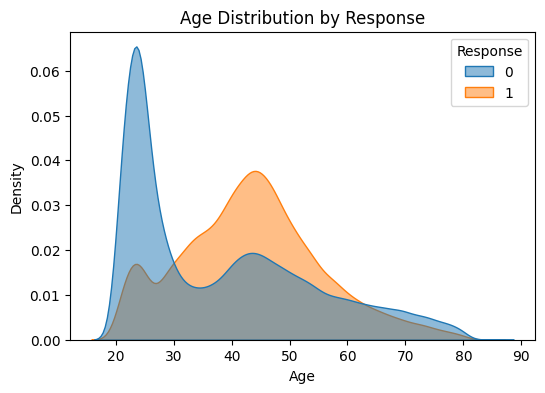

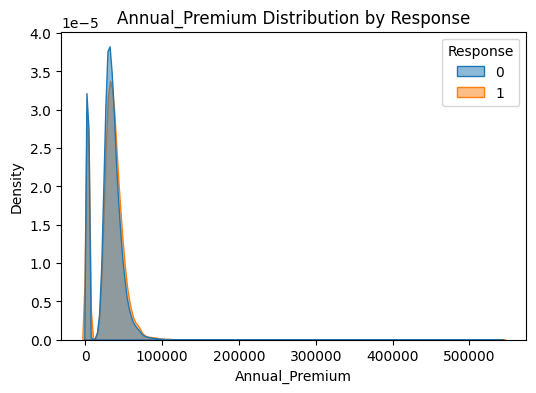

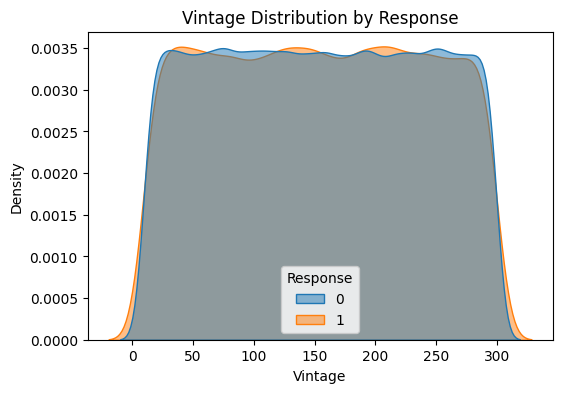

In [48]:
categorical_vars = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']
numerical_vars = ['Age', 'Annual_Premium', 'Vintage']

for col in numerical_vars:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=train_data, x=col, hue="Response", common_norm=False, fill=True, alpha=0.5)
    plt.title(f"{col} Distribution by Response")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()

#### Categorical Variable Analysis - Key Insights
- `Previously_Insured` and `Vehicle_Damage` are the strongest categorical predictors of response.
- `Vehicle Age` also provides strong segmentation power, especially distinguishing between older vs. newer cars.
- `Gender` has minimal predictive power, while `Driving License` serves more as a basic eligibility condition than a differentiator.
- Together, these variables highlight that interest in vehicle insurance is strongly driven by exposure to risk (damage history, vehicle age) and lack of existing coverage.


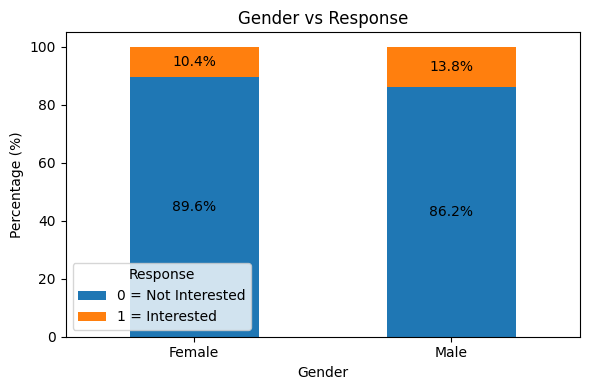

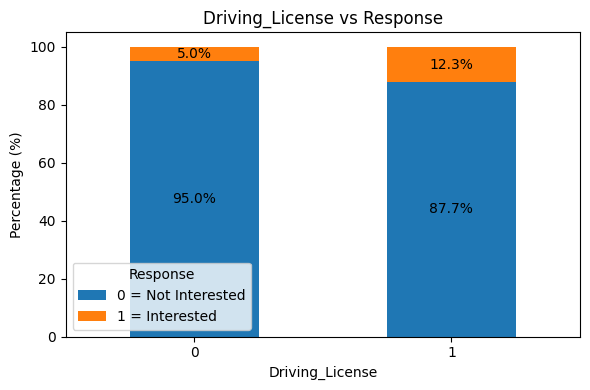

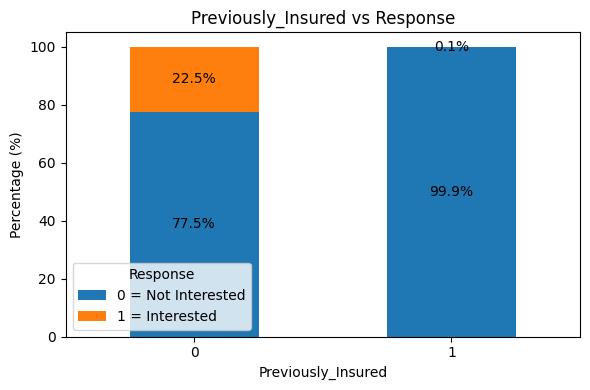

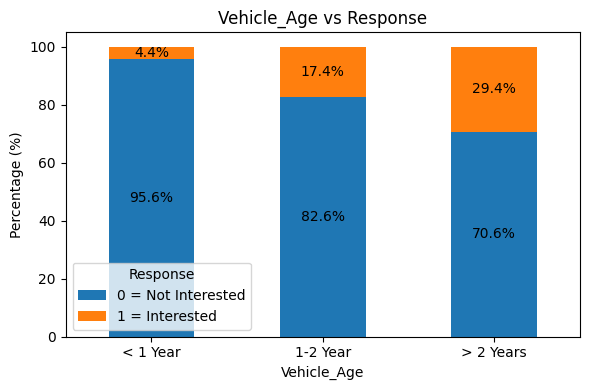

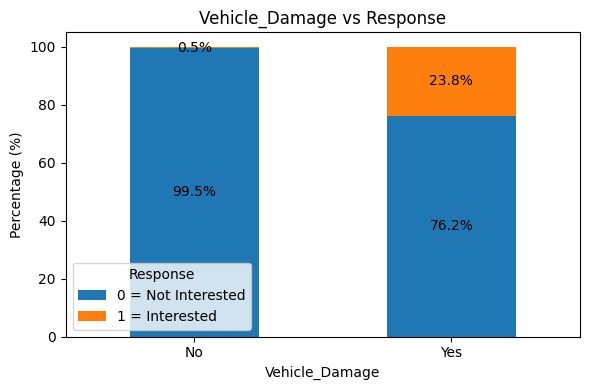

In [49]:
warnings.filterwarnings("ignore")
order_map = {
    'Vehicle_Age': ["< 1 Year", "1-2 Year", "> 2 Years"],
    'Vehicle_Damage': ["No", "Yes"],
    'Gender': ["Female", "Male"],
    'Driving_License': [0, 1],
    'Previously_Insured': [0, 1],
}

for col in categorical_vars:
    if col in order_map:
        train_data[col] = pd.Categorical(train_data[col], categories=order_map[col], ordered=True)

for col in categorical_vars:
    dist = pd.crosstab(train_data[col], train_data['Response'], normalize='index') * 100
    if pd.api.types.is_categorical_dtype(train_data[col].dtype):
        dist = dist.reindex(train_data[col].cat.categories)

    ax = dist.plot(kind='bar', stacked=True, figsize=(6,4),
                   color=["#1f77b4", "#ff7f0e"])

    plt.title(f"{col} vs Response")
    plt.ylabel("Percentage (%)")
    plt.xlabel(col)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%', label_type='center', color='black', fontsize=10)

    plt.legend(title="Response", labels=["0 = Not Interested", "1 = Interested"])
    plt.tight_layout()
    plt.show()

In [50]:
# Feature Engineering for modeing.
def data_cleaning(df):
    df['Vehicle_Age'] = df['Vehicle_Age'].replace({'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0}).astype(int)
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
    df['Gender'] = df['Gender'].map({"Male": 1, 'Female': 0})
    return(df)
train = data_cleaning(train_data)
test = data_cleaning(test_data)

## Baseline Predictive Model

### Logistic Regression

In [51]:
X = train.drop(columns=['Response','id'])
y = train['Response'].astype(int)

# ----------------------
# Split train_data into train/valid
# ----------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------
# Scaling
# ----------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# ----------------------
# Logistic Regression Model
# ----------------------
lr_model = LogisticRegression(max_iter=1000, class_weight="balanced")
lr_model.fit(X_train_scaled, y_train)

# ----------------------
# Predict on Test Data
# ----------------------
y_valid_pred = lr_model.predict(X_valid_scaled)
y_valid_proba = lr_model.predict_proba(X_valid_scaled)[:,1]

print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("AUC:", roc_auc_score(y_valid, y_valid_proba))
print("Classification Report:\n", classification_report(y_valid, y_valid_pred))
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_valid_pred))

Accuracy: 0.6402219831544699
AUC: 0.8343460880225028
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.98      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222

Confusion Matrix:
 [[39678 27202]
 [  221  9121]]


## Advanced Model
#### Random Forest

In [52]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)
rf_pred_proba = rf_model.predict_proba(X_valid_scaled)[:,1]
print("Random Forest AUC:", roc_auc_score(y_valid, rf_pred_proba))
print(classification_report(y_valid, (rf_pred_proba>=0.5).astype(int)))

Random Forest AUC: 0.8546612705111146
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     66880
           1       0.28      0.93      0.43      9342

    accuracy                           0.69     76222
   macro avg       0.63      0.80      0.61     76222
weighted avg       0.90      0.69      0.75     76222



#### XGBoost

In [53]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),  # 處理不平衡
    eval_metric="auc",
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred_proba = xgb_model.predict_proba(X_valid_scaled)[:,1]
print("XGBoost AUC:", roc_auc_score(y_valid, xgb_pred_proba))
print(classification_report(y_valid, (xgb_pred_proba>=0.5).astype(int)))

XGBoost AUC: 0.8576662467515639
              precision    recall  f1-score   support

           0       0.98      0.68      0.81     66880
           1       0.29      0.92      0.44      9342

    accuracy                           0.71     76222
   macro avg       0.64      0.80      0.62     76222
weighted avg       0.90      0.71      0.76     76222



#### Netural Network

In [54]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=50,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)
mlp_pred_proba = mlp_model.predict_proba(X_valid_scaled)[:, 1]
print("Neural Network AUC:", roc_auc_score(y_valid, mlp_pred_proba))
print(classification_report(y_valid, (mlp_pred_proba>=0.5).astype(int)))

Neural Network AUC: 0.8523904222608396
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.51      0.01      0.02      9342

    accuracy                           0.88     76222
   macro avg       0.69      0.50      0.48     76222
weighted avg       0.83      0.88      0.82     76222



## Model Evaluation
### 1. Explanation of Evaluation Metrics
* ROC-AUC (Area Under the Receiver Operating Characteristic Curve):    

Measures the model’s ability to distinguish between the two classes (interested vs. not interested). A value closer to 1.0 indicates stronger discriminative power.
* Accuracy:    

The proportion of all predictions (0 and 1) that were correct. In imbalanced datasets, accuracy can be misleading because the model can achieve a high score by mostly predicting the majority class.
* Precision:    

Of all the customers the model predicted as "interested" (1), how many were actually interested. High precision means fewer false positives.
* Recall (Sensitivity):    

Of all the customers who were truly interested (1), how many did the model successfully identify. High recall means fewer false negatives.

### 2. Overall Performance of Model
I trained and evaluated four models on the insurance cross-sell dataset: Logistic Regression, Random Forest, XGBoost, and a Neural Network (MLP).
* **XGBoost** achieved the highest ROC-AUC (0.858), meaning it best distinguishes interested vs. not interested customers. It also had strong recall (0.916), although its precision (0.288) was modest.
* **Random Forest** achieved a similar ROC-AUC (0.855) and slightly higher recall (0.935), but its precision (0.277) was lower than XGBoost.
* **Neural Network (MLP)** showed the highest Accuracy (0.877) and relatively strong precision (0.506), but its recall was extremely low (0.009). This means it failed to detect almost all truly interested customers.
* **Logistic Regression** had the lowest ROC-AUC (0.834), but its recall was the highest (0.976), meaning it identified nearly all interested customers, though at the cost of low precision (0.251).

In [55]:
# ---- helper ----
def metrics_row(name, y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "Model": name,
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
    }

# ---- collect model probabilities ----
probas = {
    "Logistic": y_valid_proba,          
    "RandomForest": rf_pred_proba,      
    "XGBoost": xgb_pred_proba,          
    "NeuralNet(MLP)": mlp_pred_proba,   
}

# ---- build comparison table ----
rows = []
for name, p in probas.items():
    rows.append(metrics_row(name, y_valid, p, threshold=0.5))

compare_df = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)

print("== Model Comparison (threshold=0.5) ==")
display(compare_df)

== Model Comparison (threshold=0.5) ==


,Model,ROC_AUC,Accuracy,Precision,Recall
0,XGBoost,0.857666,0.712209,0.288023,0.915864
1,RandomForest,0.854661,0.693645,0.277430,0.934596
2,NeuralNet(MLP),0.852390,0.877463,0.505618,0.009634
3,Logistic,0.834346,0.640222,0.251108,0.976343


### 3. Trade-offs
* **XGBoost and Random Forest:** balanced and strong models with both good ROC-AUC and high recall, though with modest precision.
* **Neural Network:** precision-oriented but almost useless in practice due to extremely low recall.
* **Logistic Regression:** weaker in ROC-AUC, but its very high recall makes it reliable for ensuring no interested customer is missed.

## Business Application
In an insurance cross-sell scenario, recall is more critical than precision, since failing to identify a potentially interested customer results in lost sales opportunities, while false positives only mean extra (but acceptable) marketing effort.   
   
👉 Therefore, even though XGBoost had the best ROC-AUC overall, Logistic Regression may actually be the most suitable model in this case because of its extremely high recall (0.976). This ensures that nearly all potential customers are captured, aligning with the business goal of not missing any possible cross-sell opportunities.